In [136]:
import math
import numpy as np
import pandas as pd
import sys
import re
import itertools
from functions import *
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import seaborn as sns
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10, 3)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data wrangling

#### Loaded dataframe with every actions for all students and dataframe with student pre/post scores

In [3]:
df.head(2)

,Activity,student,Time Stamp,Family,Family_tool,Family_default,Family_both,Action,Component,Outcome,...,current_#loops,current_#components,current_#battery,current_#circuitSwitch,current_#grabBagResistor,current_#lightBulb,current_#resistor,current_#seriesAmmeter,non_default_resistor_values,keep
0,a2,10009106,1363981168331,Construct,Construct,Construct,Construct,add,wire,None,...,0,0,0,0,0,0,0,0,0,True
1,a2,10009106,1363981175425,Construct,Construct,Construct,Construct,add,battery,None,...,0,0,0,0,0,0,0,0,0,True


In [4]:
df_scores.head(2)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,...,Anon Student Id,incoming_knowledge,incoming_attitude,learning1score,learning1,learning2score,learning2,split pre,split post t2,three groups
0,March,not,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,high,low,NaN,low,NaN,low,high,high,HH
1,March,scaff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,high,low,NaN,low,NaN,low,high,high,HH


#### Crop activity data to get rid of activity #3

In [7]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

#### Define LL, LH, HL and HH groups based on median split on pre and bimodal dist of post tests

In [8]:
median_learning0 = 0.45
df_scores['split pre'] = df_scores.apply (lambda row: label_learning (median_learning0,row,"z pre"),axis=1)
median_learning2 = np.median(df_scores[df_scores['split pre']=='low']['z post t2'])
df_scores['split post t2'] = df_scores.apply (lambda row: label_learning (median_learning2,row,"z post t2"),axis=1)

In [9]:
for x in ['high','low']:
    for y in ['high','low']:
        print x,y, len(set(df_scores[(df_scores['split pre']==x)&(df_scores['split post t2']==y)]['student']))

high high 22
high low 3
low high 38
low low 36


In [10]:
def label_3_groups (row):
    if row['split pre']  == 'high' and row['split post t2'] == 'high':
        return 'HH'
    if row['split pre']  == 'high' and row['split post t2'] == 'low':
        return 'HL'
    if row['split pre']  == 'low' and row['split post t2'] == 'high':
        return 'LH'
    if row['split pre']  == 'low' and row['split post t2'] == 'low':
        return 'LL'
df_scores['three groups'] = df_scores.apply (lambda row: label_3_groups (row),axis=1)

#### Convert action families into string sequences

In [14]:
def convert(action, test_granular = True):
''' 
this function converts action families into single codes more amenable for sequence interpretation
'''
    if test_granular:
        converter =  {"Construct" : "C",
        "Interface" : "I",
        "Pause" : "P",
        "Test_basic" : "T1",
        "Test_complex" : "Tm",
        "Test_other" : "To",
        "Test_simple" : "T2",
        }
    else:
        converter =  {"Construct" : "C",
        "Interface" : "I",
        "Pause" : "P",
        "Test_basic" : "T",
        "Test_complex" : "T",
        "Test_other" : "T",
        "Test_simple" : "T",
        }   
    return converter[action]

In [64]:
''' 
this is a test cell to assess regex
'''
ignore=['I', 'To']
sequence = list(df[df['student']==10009106]["Family"])

#prints raw sequence
print ''.join([convert(action) for action in sequence if convert(action) not in ignore])

#prints blocked action sequence
block = re.sub(r'([A-Z][a-z]{0,3})\1+', 
               r'\1',
               ''.join([convert(action, False) for action in sequence if convert(action, False) not in ignore]))
print block

#prints blocked action for all action families except tests
block2 = re.sub(r'([CPI])\1+', 
                r'\1',
                ''.join([convert(action) for action in sequence if convert(action) not in ignore]))
print block2

CCCPCCCCCCCCCCCCCCCCCCCCCCCCTmCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCT1T1PT1T1PT1CCCCCCCT1T1T1CCCCCCT1PT2T2T2T2PT2T2T2PT2T2PT2PT2T2T2T2CCT2T2T2T2CCT2T2T2T2T2T2PCCCCT2T2T2T2T2T2T2T2CT2T2T2T2T2T2T2PCCT2T2T2T2T2T2CT2T2T2T2T2T2T2PPCCCCCCCCPPCCCPCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCP
CPCTCTPTPTCTCTPTPTPTPTPTCTCTPCTCTPCTCTPCPCPCP
CPCTmCT1T1PT1T1PT1CT1T1T1CT1PT2T2T2T2PT2T2T2PT2T2PT2PT2T2T2T2CT2T2T2T2CT2T2T2T2T2T2PCT2T2T2T2T2T2T2T2CT2T2T2T2T2T2T2PCT2T2T2T2T2T2CT2T2T2T2T2T2T2PCPCPCP


In [78]:
'''
This creates dictionary (keys are student ID) and values are action sequences
'''
ignore=['I', 'To']
students = list(df['student'].unique())
sequences = {student:'' for student in students}
for student in students:
    sequence = list(df[df['student']==student]["Family"])
    sequences[student] = re.sub(r'([A-Z][a-z]{0,3})\1+', 
                                r'\1',
                                ''.join([convert(action, False) for action in sequence if convert(action, False) not in ignore]))

In [161]:
'''
This creates a list of possible 3 action "phrases" (short sequences of actions) that will define
the dimensions along which we will cluster students.  The phrases cannot contain the same action in a row.
'''
# actions = ['C','P','T1','T2','Tm']
actions = ['C','P','T']
phrases = []    
for action1 in actions:
    temp2 = actions[:]
    temp2.remove(action1)
    for action2 in temp2:
        temp3 = actions[:]
        temp3.remove(action2)
        for action3 in temp3:
#             temp4 = actions[:]
#             temp4.remove(action3)
#             for action4 in temp4: 
                phrases = phrases + [action1+action2+action3]

print len(phrases)             
print phrases

12
['CPC', 'CPT', 'CTC', 'CTP', 'PCP', 'PCT', 'PTC', 'PTP', 'TCP', 'TCT', 'TPC', 'TPT']


In [162]:
#testing regex for detecting number of instances a phrase appears in a student whole sequence
s = sequences[1075123]
matches = re.finditer(r'(?=(CTC))',s)
results = [match.group(1) for match in matches]
print len(results)

19


In [163]:
'''
This creates a large matrix where each row is a student and each column represent a phrase.  
Each element is the normalized count of instances that the corresponding phrase appears
in that students whole sequence.
'''

# phrases = ['TP','CP']
X=np.zeros([len(students),len(phrases)])
nn = 0
for student in students:
    mm = 0
    for phrase in phrases:
        rx = r'(?=({0}))'.format(phrase)
        matches = re.finditer(rx,sequences[student])
        X[nn,mm] = len([match.group(1) for match in matches]) / float(len(sequences[student]))
        mm += 1
    nn += 1  

In [164]:
K=3
# Number of clusters
kmeans = KMeans(n_clusters=K)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_

In [165]:
for nn in range(0, K):
    print len([label for label in labels if label == nn])

28
46
25


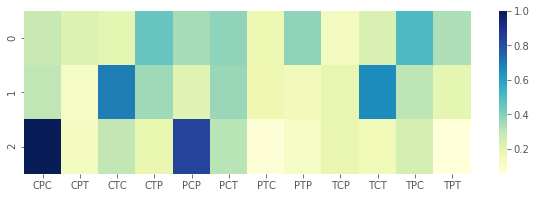

In [166]:
ax = sns.heatmap(centroids/np.max(centroids[:]), cmap="YlGnBu", xticklabels=phrases)

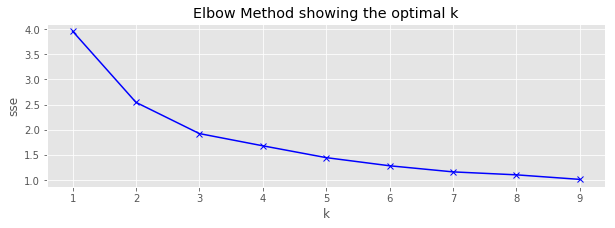

In [167]:
# k means determine k
sse = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
#     sse.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'sqeuclidean'), axis=1)))
    sse.append(kmeanModel.inertia_)

plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Elbow Method showing the optimal k')
plt.show()

#### Creating new dataframe with clusters and pre-identified groups

In [143]:
df2 = pd.DataFrame(np.array([students,labels]).transpose())
df2.columns = ['student','k-means label']
df_category = df_scores.loc[:,['student','three groups']]
df2 = df2.join(df_category.set_index('student'), on='student')
df2.head()

,student,k-means label,three groups
0,10009106,2,LL
1,1075123,2,LH
2,10942128,0,LH
3,12235124,1,LL
4,12949120,2,LH


In [144]:
df2.groupby(['k-means label', 'three groups']).size().unstack().fillna(0)

three groups,HH,HL,LH,LL
k-means label,,,,
0,7.0,0.0,7.0,11.0
1,8.0,3.0,13.0,19.0
2,7.0,0.0,18.0,6.0
